In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
csv_file = "/root/projects/pytorch_integrated_cell/test_aaegan/aaegan3Dv5_128D/struct_model/var_test_testing/all_dat.csv"
df = read_csv(csv_file)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  img_index = col_integer(),
  data_provider_index = col_integer(),
  embedding_data_provider_index = col_integer(),
  embedding_train_or_test = col_character(),
  label = col_character(),
  path = col_character(),
  train_or_test = col_character(),
  tot_inten = col_double(),
  tot_inten_recon = col_double(),
  mse_orig = col_double(),
  mse_recon = col_double(),
  pearson_orig = col_double(),
  pearson_recon = col_double()
)


In [4]:
# remove rows with missing data
df = df[complete.cases(df), ]

# remove empty cols
drop_cols = c("X1", "Unnamed: 0")
df = select(df,-one_of(drop_cols))

# change data types of some cols
df %>%
    mutate(
        train_or_test=as.factor(train_or_test),
        embedding_train_or_test=as.factor(embedding_train_or_test),
        label=as.factor(label)
    ) -> df

In [5]:
# rename cols and move from mse to rmse

df %>%
    rename(
        img_dp_index=data_provider_index,
        latent_dp_index=embedding_data_provider_index,
        latent_phase=embedding_train_or_test,
        img_phase=train_or_test,
        img_path=path,
        img_label=label
    ) %>%
    mutate(rmse_orig=sqrt(mse_orig)) %>%
    mutate(rmse_recon=sqrt(mse_recon)) %>%
    select(-one_of("mse_orig","mse_recon")) ->
    df

In [ ]:
# create a master index for the latent inds and a structure label for the latent location

df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    rename(latent_index=img_index,
           latent_dp_index=img_dp_index,
           latent_phase=img_phase,
           latent_label=img_label) %>%
    inner_join(df) ->
    df

Joining, by = c("latent_dp_index", "latent_phase")


In [8]:
# filter down to cells that have their own embedding sampled

df %>%
    filter(latent_index==img_index) %>%
    select(img_index) -> df_ims_with_self_sample
df %>%
    filter(img_index %in% df_ims_with_self_sample$img_index) ->
    df_small

In [9]:
# create means and self error cols

df %>%
    filter(latent_index==img_index) %>%
    mutate(self_rmse_orig=rmse_orig,
           self_rmse_recon=rmse_recon,
           self_pearson_orig=pearson_orig,
           self_pearson_recon=pearson_recon
          ) %>%
    select(img_index,
           self_rmse_orig,
           self_rmse_recon,
           self_pearson_orig,
           self_pearson_recon) ->
    df_self

df %>%
    inner_join(df_self) %>%
    arrange(img_index) ->
    df

df %>%
    group_by(img_index, img_label, img_phase) %>%
    summarize(mean_rmse_orig=mean(rmse_orig),
              mean_rmse_recon=mean(rmse_recon),
              mean_pearson_orig=mean(pearson_orig),
              mean_pearson_recon=mean(pearson_recon)) ->
    df_mean_stats

df_mean_stats %>%
    inner_join(df) ->
    df_mean_vs_all

df_mean_stats %>%
    inner_join(df_self) ->
    df_mean_vs_self

Joining, by = "img_index"
Joining, by = c("img_index", "img_label", "img_phase")


In [30]:
df_save = df

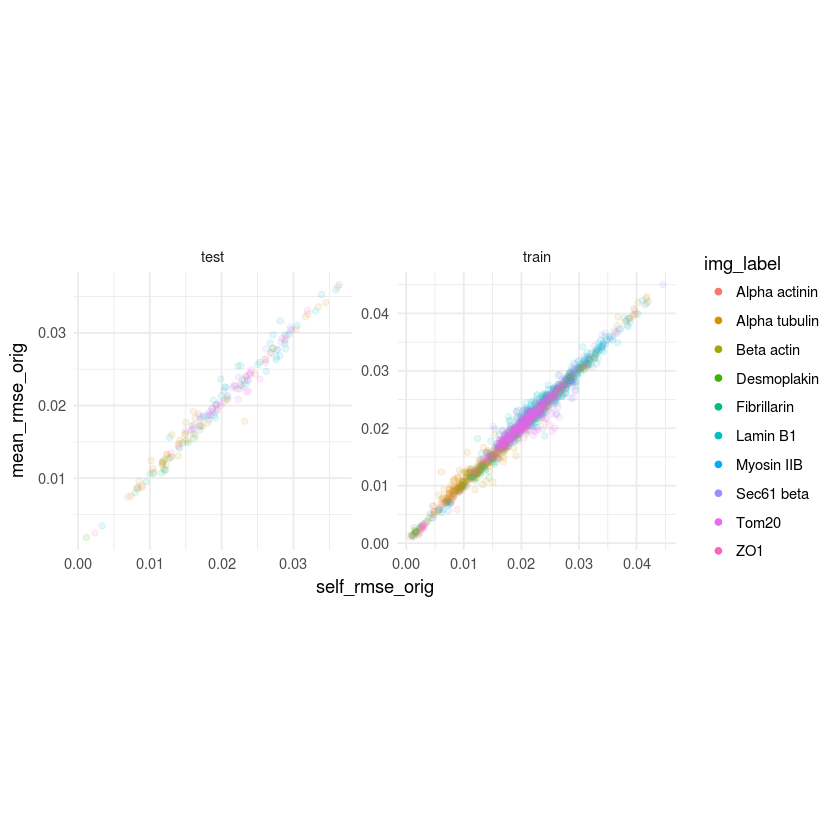

In [17]:
df_mean_vs_self %>%
    ggplot(aes(x=self_rmse_orig, y=mean_rmse_orig, color=img_label, fill=img_label)) +
        geom_point(alpha=0.1) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

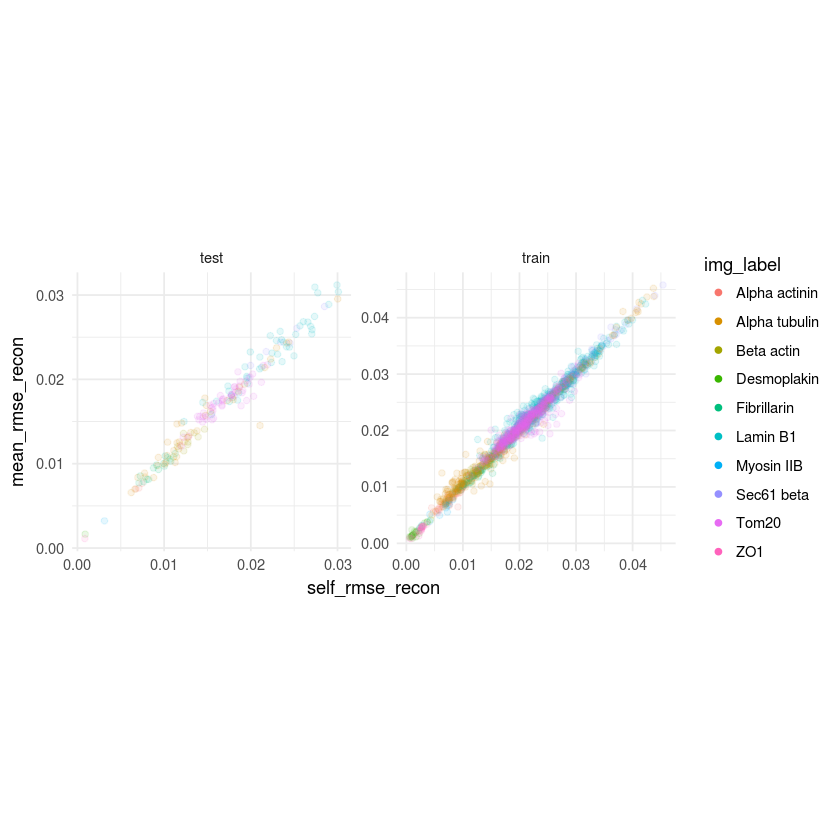

In [18]:
df_mean_vs_self %>%
    ggplot(aes(x=self_rmse_recon, y=mean_rmse_recon, color=img_label, fill=img_label)) +
        geom_point(alpha=0.1) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

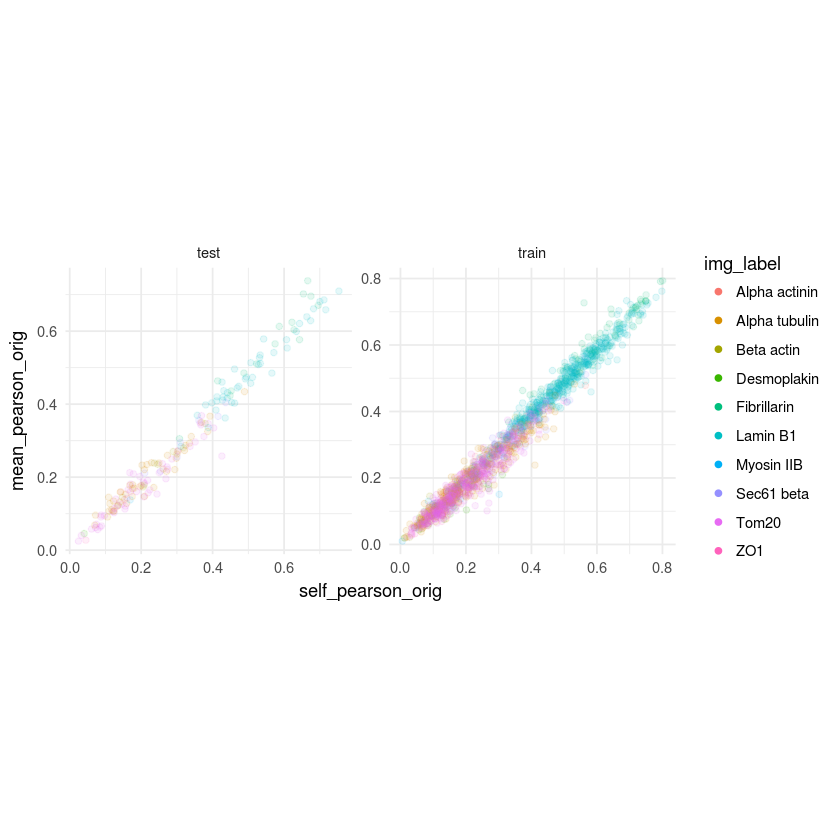

In [19]:
df_mean_vs_self %>%
    ggplot(aes(x=self_pearson_orig, y=mean_pearson_orig, color=img_label, fill=img_label)) +
        geom_point(alpha=0.1) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

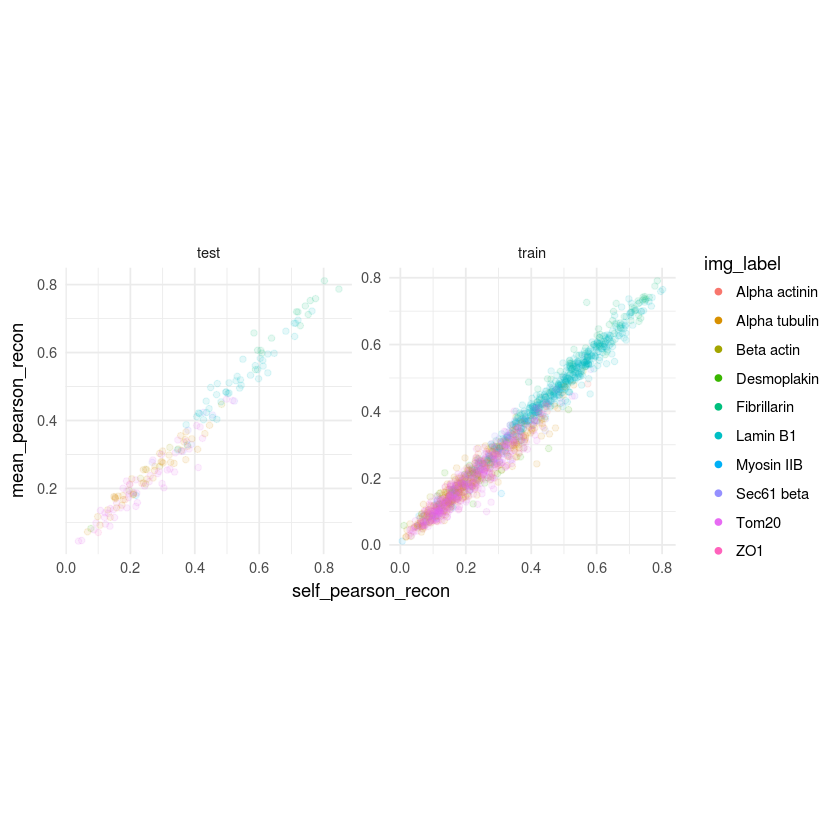

In [20]:
df_mean_vs_self %>%
    ggplot(aes(x=self_pearson_recon, y=mean_pearson_recon, color=img_label, fill=img_label)) +
        geom_point(alpha=0.1) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

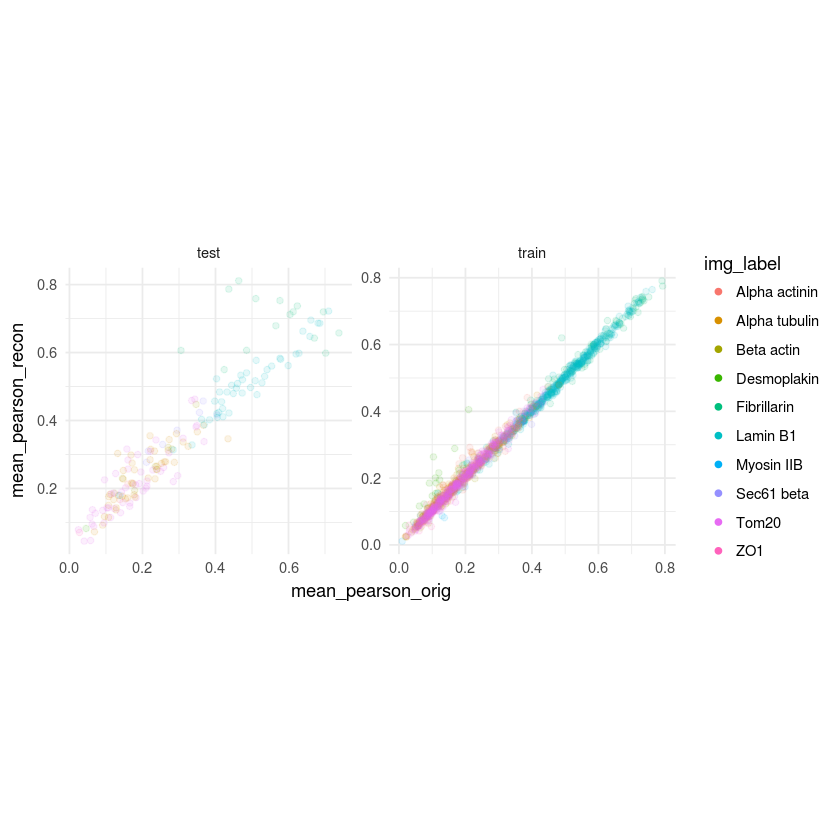

In [28]:
df_mean_vs_self %>%
    ggplot(aes(x=mean_pearson_orig, y=mean_pearson_recon, color=img_label, fill=img_label)) +
        geom_point(alpha=0.1) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

In [22]:
df_mean_vs_self %>% head

img_index,img_label,img_phase,mean_rmse_orig,mean_rmse_recon,mean_pearson_orig,mean_pearson_recon,self_rmse_orig,self_rmse_recon,self_pearson_orig,self_pearson_recon
3,Alpha actinin,train,0.012326230,0.011963425,0.11143866,0.11818265,0.012457648,0.012093362,0.0953261,0.102533
7,Alpha actinin,train,0.015516207,0.015193712,0.18446269,0.20283856,0.015457132,0.015118172,0.1984960,0.218636
17,Alpha actinin,train,0.006853615,0.006924343,0.08404588,0.08680777,0.006527277,0.006602829,0.0985807,0.101560
26,Alpha actinin,train,0.006864235,0.006751811,0.22021020,0.27284884,0.007731210,0.007636396,0.1946010,0.238426
34,Alpha actinin,train,0.009219050,0.008365412,0.14807810,0.13932157,0.008199525,0.007310479,0.2063450,0.191247
35,Alpha actinin,train,0.009164710,0.008261432,0.21622672,0.27922601,0.009321233,0.008449480,0.2057050,0.263010


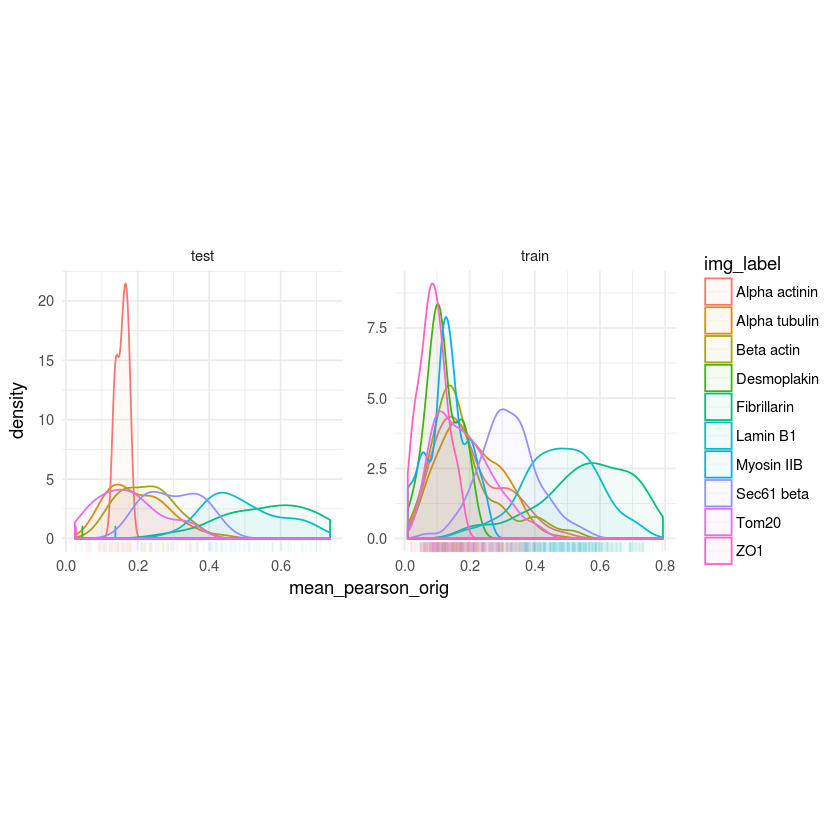

In [36]:
df_mean_vs_self %>%
    ggplot(aes(x=mean_pearson_orig, color=img_label, fill=img_label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    facet_wrap(~img_phase, scales = 'free') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines"))